In [1]:
!pip install kaggle

In [2]:
import json
from pathlib import Path
def rtouch(self,mode=0o666,exist_ok=True):
    self.parent.mkdir(parents=True,exist_ok=True)
    self.touch(mode,exist_ok)
setattr(Path,'rtouch',rtouch)

In [5]:
home_directory=Path('/home/fast')
kaggle_username="moerilily"
kaggle_key="532db79cad4ec8a1ec23fa33fbfcf775"

In [6]:
p=home_directory/'.kaggle/kaggle.json'
p.rtouch(mode=0o700)

In [7]:
p.write_text(json.dumps({"username":kaggle_username,"key":kaggle_key}))
json.loads(p.read_text())

{'username': 'moerilily', 'key': '532db79cad4ec8a1ec23fa33fbfcf775'}

In [8]:
import kaggle

In [9]:
kaggle.api.competition_download_files('state-farm-distracted-driver-detection',path=home_directory/'.fastai/data/distracted-drivers',quiet=False)

state-farm-distracted-driver-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
from fastai2.data.external import *
from fastai2.vision.all import *
from math import isclose
import pandas as pd

In [11]:
file_extract(home_directory/'.fastai/data/distracted-drivers/state-farm-distracted-driver-detection.zip')

In [12]:
table=pd.read_csv(home_directory/'.fastai/data/distracted-drivers/driver_imgs_list.csv')
table

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [13]:
samples=4
valid_subjects=table.groupby('subject').count().sample(n=samples)
while(True):
    try: 
        assert(isclose(valid_subjects.img.sum(),22424*.20,rel_tol=1e-03))
        train_classes=table[~table.subject.isin(valid_subjects.index)].classname.unique()
        valid_classes=table[table.subject.isin(valid_subjects.index)].classname.unique()
        assert((train_classes==valid_classes).all())
        break
    except AssertionError as e:
        valid_subjects=table.groupby('subject').count().sample(n=samples)
print(valid_subjects)
valid_subjects=valid_subjects.index.to_numpy()
table['valid']=table.subject.isin(valid_subjects)

         classname   img
subject                 
p026          1196  1196
p024          1226  1226
p081           823   823
p021          1237  1237


In [14]:
class DataFrameSplitter:
    def __init__(self,df):
        store_attr(self,'df')
    def __call__(self,o,**kwargs):
        path_df=pd.DataFrame([img.name for img in o],columns=['img'])
        valids=path_df.join(self.df.set_index('img'),on='img',rsuffix='r').valid
        return path_df[~valids].index,path_df[valids].index

Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm


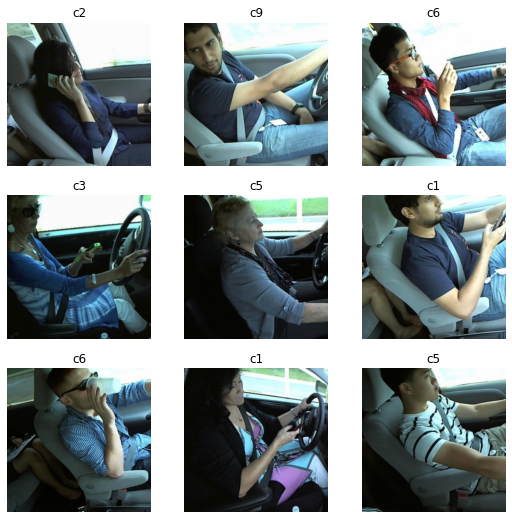

In [15]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.001),#DataFrameSplitter(table),
                 get_y=parent_label,
                 item_tfms=Resize(480),
                 batch_tfms=aug_transforms(do_flip=False,size=480, min_scale=0.75))
dls = pets.dataloaders(Path('/home/fast/.fastai/data/distracted-drivers/imgs/train'),verbose=True,bs=32)
dls.show_batch()

In [16]:
learn = cnn_learner(dls, resnet50, metrics=error_rate,wd=0.1).to_fp16()

(0.005754399299621582, 0.004365158267319202)

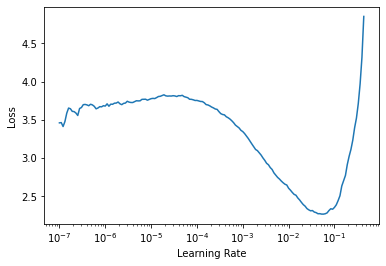

In [17]:
learn.lr_find(num_it=200)

In [ ]:
learn.fit_one_cycle(1,lr_max=0.0075) #ep1 lr0.12 wd0.05 vloss0.29

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5,lr_max=1.3e-05) #5 epochs = 0.35

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('big_submission4')

In [ ]:
load_model(Path('/home/fast/fastai2/anime/nbs/models/big_submission4.pth'),learn.model,learn.opt)

In [ ]:
test_dl=dls.test_dl(Path('/home/fast/.fastai/data/distracted-drivers/imgs/test/').ls(),bs=32)

In [ ]:
preds=learn.get_preds(dl=test_dl)

In [ ]:
test_df=pd.DataFrame(preds[0].numpy(),columns=['c'+str(i) for i in range(10)])

In [ ]:
test_df['img']=pd.Series([p.name for p in Path('/home/fast/.fastai/data/distracted-drivers/imgs/test/').ls()])
test_df=test_df.set_index('img')

In [ ]:
test_df.to_csv('seventh_submission.csv')

In [ ]:
kaggle.api.competition_submit('seventh_submission.csv','my seventh submission','state-farm-distracted-driver-detection')

In [ ]:
dls.show_batch(max_n=64)

In [ ]:
test_dl.show_batch(max_n=64)

In [ ]:
!pip install ipywidgets

In [ ]:
from fastai2.vision.widgets import *

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
table[table.classname=='c9'].count()

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(30)

In [ ]:
dls.train.show_batch(max_n=32)

In [ ]:
dls.valid.show_batch(max_n=32)